In [62]:
import sys, os
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

"""
First three steps with Euler, then use Adams-Bashforth:
y_{n+3} = y_{n+2}+(h/12)*(23*f_{n+2}-16f_{n+1}+5f_{n})

with y' = f(y)

"""


v = 0.1
delta = 0.1
epsilon = 0.25
initialConcentration = 1.0
distanceBetweenElectrodes = 200.0
gridSize = 1000
dx = 2.0/(1.0*gridSize)
celSize = (distanceBetweenElectrodes /(1.0*gridSize))
deltat = 0.000005
maxT = 0.05

verwijdermij = 0


In [87]:
def differentiateList(lst,dx):
    #todo: this function creates a new list several times: make a itertools variant to prevent this
    diff = np.diff(lst)
    diff = np.divide(diff,dx)
    derivative = [0.5*diff[i]+0.5*diff[i+1] for i in range(len(diff)-1)]
    derivative = np.concatenate([[diff[0]],derivative,[diff[-1]]])
    return derivative

def updatePhi(rho,oldPhi):
    global verwijdermij
    newPhi = np.divide(np.cumsum(np.cumsum(np.insert(rho,0,0)))[:-1],+(epsilon*epsilon/(dx**2)))
    newPhi = np.subtract(newPhi,np.mean(newPhi))
    if(verwijdermij==4):
        plt.figure()
        plt.plot(newPhi)
        plt.show()
    verwijdermij += 1
    newPhi=np.add(newPhi,initialPhi)
    #newPhi[0] = v+delta*epsilon*(oldPhi[1]-oldPhi[0])/dx
    #newPhi[-1] = -v-delta*epsilon*(oldPhi[-2]-oldPhi[-1])/dx
    newPhi[0] = v
    newPhi[-1] = -v
    return newPhi

def calculateNew_fc(rho, dc, dphi):
    fc = np.multiply(rho,dphi)
    fc = np.add(fc,dc)
    fc = differentiateList(fc,dx)
    fc = np.multiply(epsilon,fc)
    #boundary conditions for frho:
    #fc[0] = +(0.5*rho[0])*dphi[0]
    #fc[-1] = -(0.5*rho[-1])*dphi[-1]
    
    return fc
    
def calculateNew_frho(c, drho, dphi):
    #frho0
    frho = np.multiply(c,dphi)
    frho = np.add(frho,drho)
    frho = differentiateList(frho,dx)
    frho = np.multiply(epsilon,frho)
    #boundary conditions for frho:
    t= frho[0]
    #frho[0] = +(0.5*c[0])*dphi[0]
    #frho[-1] = -(0.5*c[-1])*dphi[-1]
    #print(t, frho[0], t-frho[0])

    return frho

In [88]:
#Initialise the potential, concentration and charge distribution in the grid:

phi = np.zeros(gridSize)
phi0 = np.zeros(gridSize)
phi1 = np.zeros(gridSize)
phi2 = np.zeros(gridSize)
rho0 = np.zeros(gridSize)
rho1 = np.zeros(gridSize)
rho2 = np.zeros(gridSize)
c0 = np.full(gridSize,initialConcentration)
c1 = np.full(gridSize,initialConcentration)
c2 = np.full(gridSize,initialConcentration)

#set the initial potential on v. This differs from Bazant where the stern layer is taken into account


phi = [p-2*v*(1.0*i/(1.0*len(phi)-1))+v for i, p, in enumerate(phi)]
phi0 = [p-2*v*(1.0*i/(1.0*len(phi0)-1))+v for i, p, in enumerate(phi0)]
phi0[0] = v
phi0[-1] = -v
phi[0] = v
phi[-1] = -v



print(np.sum(phi))
#and now the time derivatives of c and rho that are needed for the AB integration.

frho0 = np.zeros(gridSize)
frho1 = np.zeros(gridSize)
frho2 = np.zeros(gridSize)
fc0 = np.zeros(gridSize)
fc1 = np.zeros(gridSize)
fc2 = np.zeros(gridSize)


initialPhi = phi.copy()

-3.5527136788e-15


In [89]:
"""

The boundary conditions that Bazant uses:

fc_n[0] = fc_n[-1]  = 0
frho_n[0] = frho_n[-1] = 0
phi[0] = - phi[-1] = v-delta*epsilon*phi'


"""


"""
First three steps with Euler: this is done by first calculating the 
potential phi between the electrodes and then calculating
f0 or both c and rho, then calculate time steps. Repeat for f1 and f2,
then do the AB algorithm
"""






#update phi

phi = updatePhi(rho0,phi)


#new f's step 1
dphi = differentiateList(phi,dx)
drho = differentiateList(rho0,dx)
dc = differentiateList(c0,dx)
fc0 = calculateNew_fc(rho0, dc, dphi)

frho0 = calculateNew_frho(c0, drho, dphi)


print(np.sum(c0),np.sum(rho0),np.sum(phi),np.sum(fc0), np.sum(frho0))

#Euler step 1

c1 = np.add(c0,np.multiply(deltat,fc0))
rho1 = np.add(rho0,np.multiply(deltat,frho0))

#update phi for step 2


phi = updatePhi(rho1,phi)



#new f's step 2
dphi = differentiateList(phi,dx)
drho = differentiateList(rho1,dx)
dc = differentiateList(c1,dx)
fc1 = calculateNew_fc(rho1, dc, dphi)
frho1 = calculateNew_frho(c1, drho, dphi)

#Euler step 2
c2 = np.add(c1,np.multiply(deltat,fc1))
rho2 = np.add(rho1,np.multiply(deltat,frho1))




#update phi step 3
phi = updatePhi(rho2,phi)


print(np.sum(c1),np.sum(rho1),np.sum(phi),np.sum(fc1), np.sum(frho1))

#new f's step 3
dphi = differentiateList(phi,dx)
drho = differentiateList(rho2,dx)
dc = differentiateList(c2,dx)
fc2 = calculateNew_fc(rho2, dc, dphi)
frho2 = calculateNew_frho(c2, drho, dphi)

#now AB instead of Euler can be used, because f_0, f_1 and f_2 are calculated:



#calculate new c0:

c0 = np.add(
            np.add( np.multiply(23.0,fc2),np.multiply(-16.0,fc1)),
                    np.multiply(5.0,fc0))

c0 = np.multiply(deltat/12.0,c0)
c0 = np.add(c2,c0)

#calculate new rho0

rho0 = np.add(
            np.add( np.multiply(23.0,frho2),np.multiply(-16.0,frho1)),
                    np.multiply(5.0,frho0))

rho0 = np.multiply(deltat/12.0,rho0)
rho0 = np.add(rho2,rho0)

#Now the initialisation is finished: looping may start:



for t in np.arange(0,maxT,deltat):
    #update phi
    phi = updatePhi(rho0,phi)
    dphi = differentiateList(phi,dx)
    
    if(np.sum(phi)*np.sum(phi) > 0.0001):
        print("potentiaal asssymetrisch: sum phi = %f " % np.sum(phi))
        break
    if(np.sum(rho0)*np.sum(rho0) > 0.0001):
        print("rho0 asssymetrisch: sum rho0 = %f " % np.sum(rho0))
        break

    #update f's

    frho0 = frho1
    frho1 = frho2
    frho2 = calculateNew_frho(c0, drho, dphi)
    fc0 = fc1
    fc1 = fc2
    fc2 = calculateNew_fc(rho0, dc, dphi)

    #timestep:
    c1 = np.add(
            np.add( np.multiply(23.0,fc2),np.multiply(-16.0,fc1)),
                    np.multiply(5.0,fc0))

    c1 = np.multiply(deltat/12.0,c1)
    c0 = np.add(c1,c0)

    c0[0] = +(0.5*rho0[0]])*dphi[0]
    c0[-1] = -(0.5*rho0[-1])*dphi[-1]
    
    
    rho1 = np.add(
            np.add( np.multiply(23.0,frho2),np.multiply(-16.0,frho1)),
                    np.multiply(5.0,frho0))

    rho1 = np.multiply(deltat/12.0,rho1)
    rho0 = np.add(rho1,rho0)
    
    drho = differentiateList(rho0,dx)
    dc = differentiateList(c0,dx)
    
    

1000.0 0.0 -0.00500500500501 0.0 -233.358358358
1000.0 -0.00116679179179 -0.786571321335 0.0296052011771 -202.516205987
potentiaal asssymetrisch: sum phi = -0.791942 


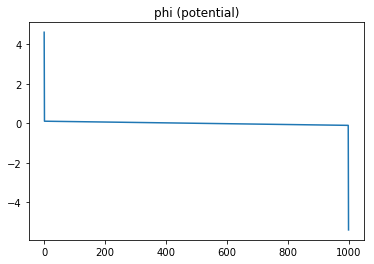

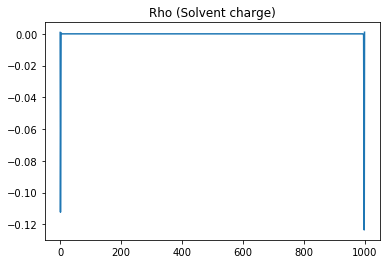

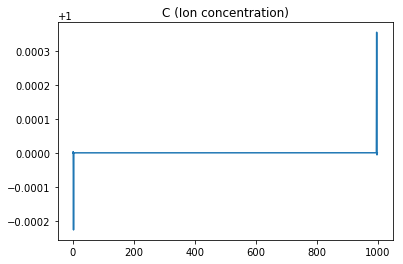

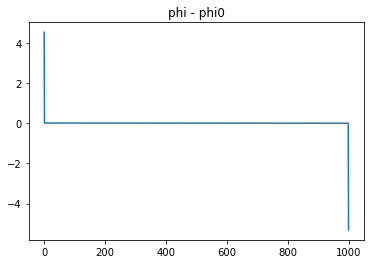

In [90]:
plt.figure()
plt.title("phi (potential)")
plt.plot(phi,'-')
plt.show()

plt.figure()
plt.title("Rho (Solvent charge)")
plt.plot(rho0,'-')
plt.show()

plt.figure()
plt.title("C (Ion concentration)")
plt.plot(c0,'-')
plt.show()

plt.figure()
plt.title("phi - phi0")
plt.plot(np.subtract(phi,initialPhi),'-')
plt.show()




In [95]:
-v-delta*epsilon*(phi[-2]-phi[-1])/dx

-66.436841410352898

In [96]:
v+delta*epsilon*(phi[1]-phi[0])/dx


-56.337277075421078

In [98]:
phi[0]

4.6200853020548109